In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as tsaplots
import warnings
warnings.filterwarnings("ignore")

In [68]:
data = pd.read_csv('data/SP500dailydata.csv')

In [69]:
data.info()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(data['Date'])
data= data.drop('Date',axis=1)
data= data.dropna()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   2501 non-null   object 
 1   sp_500_prev_day_close  2501 non-null   float64
 2   vix_prev_day           2501 non-null   float64
 3   nasdaq_prev_day        2501 non-null   float64
 4   russell_2000_prev_day  2501 non-null   float64
 5   prev_volume            2502 non-null   int64  
 6   close_price            2501 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.0+ KB


,sp_500_prev_day_close,vix_prev_day,nasdaq_prev_day,russell_2000_prev_day,prev_volume,close_price
Date,,,,,,
2024-10-08,5695.94,22.64,17923.90,26.01,49964688,5751.13
2024-08-23,5570.64,17.55,17619.35,25.20,56121461,5634.61
2016-05-26,2090.54,13.90,4894.89,17.73,79221531,2090.10
2018-01-26,2839.25,11.58,7411.16,16.54,84587312,2872.87
2020-09-21,3319.47,25.83,10793.28,29.55,105877906,3281.06
2020-02-03,3225.52,18.84,9150.94,20.33,113845602,3248.92
2020-05-06,2868.44,33.61,8809.12,43.72,79569938,2848.42
2021-04-22,4173.42,17.50,13950.22,26.19,66792977,4134.98
2018-02-22,2701.33,20.02,7218.23,20.47,98883742,2703.96


Below I created a column for log returns, log returns are stationary- making then more easily digestible for time series models.

In [70]:
data['log_returns'] = np.log(data['close_price']).diff().dropna()
data['points_change'] = data['close_price'].diff().dropna()
data= data.dropna()

In [71]:
data['prev_volume']=data['prev_volume'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-09-01 to 2025-08-11
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sp_500_prev_day_close  2500 non-null   float64
 1   vix_prev_day           2500 non-null   float64
 2   nasdaq_prev_day        2500 non-null   float64
 3   russell_2000_prev_day  2500 non-null   float64
 4   prev_volume            2500 non-null   int64  
 5   close_price            2500 non-null   float64
 6   log_returns            2500 non-null   float64
 7   points_change          2500 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 175.8 KB


Below I will take the average of the absolute value of the daily change in points and also the standard deviation of Log Returns which will give us metrics to compare our models to:

In [84]:
meanchangeinprice=data['points_change'].abs().mean()
stdevlogreturns=data['log_returns'].std()
print(f"Mean absolute value in the change in price: {meanchangeinprice}")
print(f"Std deviation of log returns: {stdevlogreturns}")

Mean absolute value in the change in price: 26.808356000000007
Std deviation of log returns: 0.011565975931643336


Text(0, 0.5, 'Weekly Closing Price ($)')

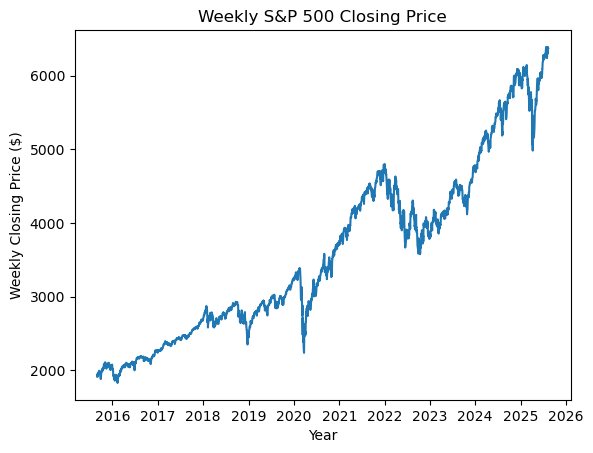

In [85]:
#This plot shows the weekly closing price of the S&P500 since 1982
plt.plot(data['close_price'])
plt.title('Weekly S&P 500 Closing Price')
plt.xlabel('Year')
plt.ylabel('Weekly Closing Price ($)')

Text(0, 0.5, 'Change in Price')

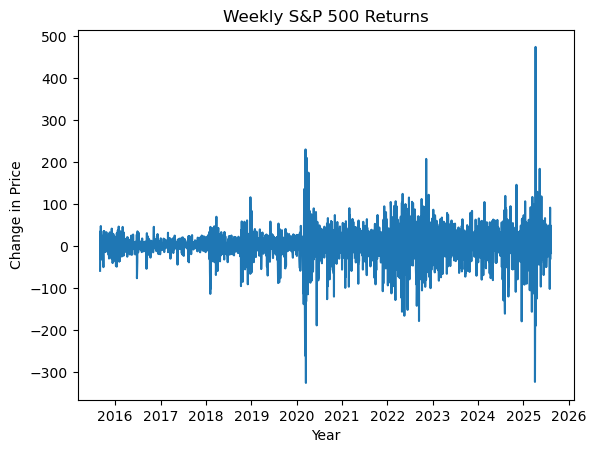

In [89]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['points_change'])
plt.title('Weekly S&P 500 Returns')
plt.xlabel('Year')
plt.ylabel('Change in Price')

Now i'll start preparing the data to run a simple linear regression on this data. I don't expect this model to be accurate at all, but it will give us an idea of how nuanced financial data is and how crucial the sequential aspect is of it.

In [98]:
X=data.drop(['close_price','log_returns','points_change'],axis=1)
y=data['close_price']

Below I have began preparing training and test sets to perform cross validation on the linear regression

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,shuffle=False)

In [100]:
numerical=['sp_500_prev_day_close','vix_prev_day','nasdaq_prev_day','russell_2000_prev_day','prev_volume']

In [101]:
polytransformer = Pipeline([         
                                    ('imputer',SimpleImputer(strategy='mean')),
                                    ('poly',PolynomialFeatures(degree = 3,include_bias=False)),
                                    ('scale',StandardScaler())
                                ])
transformer = [('polynomialtransformations',polytransformer,numerical)]
transform = ColumnTransformer(transformers = transformer,remainder='passthrough')

I have decided to forgo removing/filling any outliers, my thought is that because of the nature of financial data, outliers are important datapoints for the model to understand in this circumstance

In [102]:
initialpipe = Pipeline([
    ('transform',transform),
    ('reg',LinearRegression())
])


In [103]:
baselinemodel = initialpipe.fit(X_train,y_train)

In [104]:
preds = baselinemodel.predict(X_test)
baselineerror = mean_squared_error(preds,y_test)

In [105]:
# BELOW IS THE RMSE OF OUR INITIAL FUNCTION 
print(f"The baseline RMSE is: {np.sqrt(baselineerror)}")

The baseline RMSE is: 167.29167588007869


This standard linear regression gave us an RMSE of 167.29, which is much better than how it performed on the weekly data. This shows that on average the Linear Regression can predict the close price for the current week of the S&P 500 within 167.29 points, which is not an effective model , seeing as the average daily change is about 26.08. This is happening because the linear regression is not meant to handle sequential data like this. When you think about how quickly financial changes can happen like during COVID and in 2008, it makes sense that the model can't predict forward multiple years of how the S&P 500 is going to move.

Now that we have seen how poorly a standard linear regression performs, I will build a true baseline model, called a Random Walk, that will actually give us some information to base our proceeding models off of. 

First I'll need to make the data stationary so that it is suitable for ARIMA:

In [138]:
diffdata= data.replace([np.inf, -np.inf], np.nan)
diffdata = diffdata.fillna(method='bfill')
diffdata=diffdata.diff()
diffdata=diffdata.dropna()

In [139]:
diffdata.info()
X1=diffdata.drop(['log_returns','close_price','points_change'],axis=1)
y1=diffdata['log_returns']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2015-09-02 to 2025-08-11
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sp_500_prev_day_close  2499 non-null   float64
 1   vix_prev_day           2499 non-null   float64
 2   nasdaq_prev_day        2499 non-null   float64
 3   russell_2000_prev_day  2499 non-null   float64
 4   prev_volume            2499 non-null   float64
 5   close_price            2499 non-null   float64
 6   log_returns            2499 non-null   float64
 7   points_change          2499 non-null   float64
dtypes: float64(8)
memory usage: 175.7 KB


In [173]:
X1_train,X1_test,y1_train, y1_test = train_test_split(X1,y1,test_size=0.20,shuffle=False)

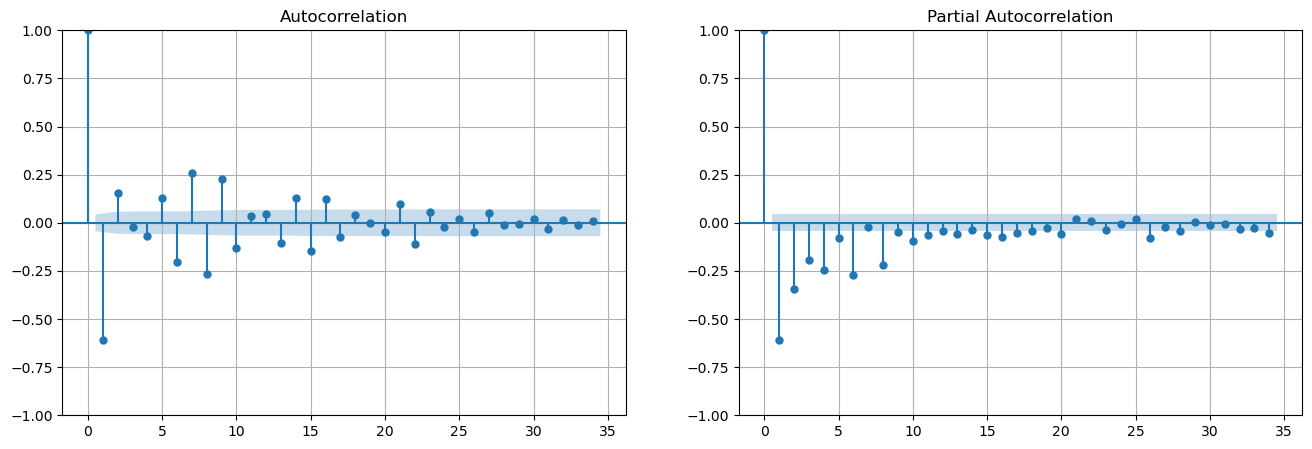

In [174]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y1_train, ax = ax[0]);
ax[0].grid()
plot_pacf(y1_train, ax = ax[1], method = 'ywm');
ax[1].grid()

In [175]:
randomwalk = SARIMAX(y1_train, order=(0, 1, 0), trend='c').fit()

In [176]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
randomwalk_preds = randomwalk.predict(start=start_index, end=end_index,dynamic=True)
random_mse_test = mean_squared_error(randomwalk_preds, y1_test)
### ANSWER CHECK
print(randomwalk_preds)
print(random_mse_test)
print(f" RMSE: {np.sqrt(random_mse_test)}")

1999   -0.001346
2000   -0.001370
2001   -0.001395
2002   -0.001420
2003   -0.001445
          ...   
2494   -0.013603
2495   -0.013628
2496   -0.013653
2497   -0.013678
2498   -0.013702
Name: predicted_mean, Length: 500, dtype: float64
0.00028312926021498136
 RMSE: 0.01682644526377991


The Random Walk gave us a baseline RMSE of .028, which is above the std dev of log returns, meaning that the model is not actually predictive.

In [177]:
arma = ARIMA(y1_train, order = (1, 0, 1)).fit()

In [178]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
preds = arma.predict(start=start_index, end=end_index,dynamic=True)
mse_test = mean_squared_error(preds, y1_test)
### ANSWER CHECK
print(preds)
print(mse_test)
print(f" RMSE: {np.sqrt(mse_test)}")

1999    0.001530
2000   -0.000277
2001    0.000046
2002   -0.000012
2003   -0.000002
          ...   
2494   -0.000003
2495   -0.000003
2496   -0.000003
2497   -0.000003
2498   -0.000003
Name: predicted_mean, Length: 500, dtype: float64
0.00021385348920319218
 RMSE: 0.01462373034499721


In [179]:
preds.tail(300)

2199   -0.000003
2200   -0.000003
2201   -0.000003
2202   -0.000003
2203   -0.000003
          ...   
2494   -0.000003
2495   -0.000003
2496   -0.000003
2497   -0.000003
2498   -0.000003
Name: predicted_mean, Length: 300, dtype: float64

I Decided against replacing any outliers because financial data is known to have spikes for certain economic reasons

In [180]:
sarimax = SARIMAX(y1_train,exog=X1_train,  order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)).fit()

In [181]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1999
Model:               SARIMAX(1, 0, 1)   Log Likelihood                5980.625
Date:                Tue, 12 Aug 2025   AIC                         -11945.249
Time:                        10:49:20   BIC                         -11900.446
Sample:                             0   HQIC                        -11928.798
                               - 1999                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sp_500_prev_day_close    -0.0004   1.29e-05    -30.794      0.000      -0.000      -0.000
vix_prev_day             -0.0003   5.32e-05     -4.734      0.000      -0.000      -0.000
nasdaq_prev_day        3.403e-05   4.06e-06      8.385      0.000    2.61e-05     4.2e-05
russell_2000_prev_day     0.0020   5.09e-05     40.001      0.000       0.002       0.002
prev_volume            4.512e-12   7.23e-12      0.624      0.533   -9.66e-12    1.87e-11
ar.L1                    -0.5283   1.75e-07  -3.01e+06      0.000      -0.528      -0.528
ma.L1                     0.4883   1.67e-07   2.92e+06      0.000       0.488       0.488
sigma2                    0.0001    1.8e-06     81.498      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             13297.10
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+21. Standard errors may be unstable.
"""

In [182]:
sarimax_start_index = len(y1_train)
sarimax_end_index = len(y1_train) + len(y1_test) - 1
sarimax_preds = sarimax.predict(start=start_index, end=end_index, exog=X1_test,dynamic=True)
sarimax_mse_test = mean_squared_error(sarimax_preds, y1_test)
### ANSWER CHECK
print(sarimax_preds)
print(sarimax_mse_test)

1999   -0.002479
2000   -0.005500
2001    0.017146
2002    0.008936
2003    0.010181
          ...   
2494   -0.027401
2495    0.007663
2496   -0.010521
2497    0.004458
2498   -0.014417
Name: predicted_mean, Length: 500, dtype: float64
0.00014800254703502125


In [183]:
print(f" RMSE: {np.sqrt(sarimax_mse_test)}")

 RMSE: 0.012165629742640587


In [184]:
np.std(y1_test)

0.014625668890608892

Below I am building an LSTM:

In [185]:
lstmdata = diffdata.drop('close_price',axis=1)
result = adfuller(lstmdata['log_returns'])

# The result is a tuple, so we can unpack it
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -15.963216
p-value: 0.000000
Critical Values:
	1%: -3.432999172889712
	5%: -2.862710384473485
	10%: -2.5673930420019127


In [186]:
train = lstmdata[:1666]
test = lstmdata[1666:]
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1666 entries, 2015-09-02 to 2022-04-13
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sp_500_prev_day_close  1666 non-null   float64
 1   vix_prev_day           1666 non-null   float64
 2   nasdaq_prev_day        1666 non-null   float64
 3   russell_2000_prev_day  1666 non-null   float64
 4   prev_volume            1666 non-null   float64
 5   log_returns            1666 non-null   float64
 6   points_change          1666 non-null   float64
dtypes: float64(7)
memory usage: 104.1 KB


In [187]:
#SCALED DATA:
train_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(train)
test_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(test)

In [188]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [189]:
def create_sequences(data, seq_length):
    X = []
    y = []
    # Loop from the beginning of the data until the end,
    # leaving enough room for the last sequence and its target
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 5])
    return np.array(X), np.array(y)



In [190]:

seq_length = 50  # For example, using the last 90 trading days

# Create sequences for the training set
X3_train, y3_train = create_sequences(train_scaled, seq_length)

# Create sequences for the testing set
X3_test, y3_test = create_sequences(test_scaled, seq_length)


In [191]:
print("X_train shape:", X3_train.shape)
print("y_train shape:", y3_train.shape)
print("X_test shape:", X3_test.shape)
print("y_test shape:", y3_test.shape)
n_timesteps = X3_train.shape[1]
n_features = X3_train.shape[2]

X_train shape: (1616, 50, 7)
y_train shape: (1616,)
X_test shape: (783, 50, 7)
y_test shape: (783,)


In [192]:
#HERE I AM BUILDING AN LSTM Recurrent Neural Network TO HOPEFULLY CAPTURE THE SEQUENTIAL NATURE OF THE DATA
lstm = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

lstm.compile(loss="mse", optimizer="adam")


In [193]:
history = lstm.fit(X3_train, y3_train,epochs=20,batch_size=32,validation_split=0.05, verbose=1)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0963 - val_loss: 0.0126
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087 - val_loss: 0.0074
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [194]:
y_pred_lstm = lstm.predict(X3_test)
# Create an empty array to hold the inverse transformed values
y_test_unscaled = np.zeros(shape=(len(y3_test), lstmdata.shape[1]))
y_pred_unscaled = np.zeros(shape=(len(y_pred_lstm), lstmdata.shape[1]))
# Replace the first column with the target values
y_test_unscaled[:, 0] = y3_test
y_pred_unscaled[:, 0] = y_pred_lstm[:, -1, 0]

# Inverse transform the data
y_test_unscaled = scaler.inverse_transform(y_test_unscaled)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_unscaled)[:, 0]


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [195]:
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 1693.5344
Root Mean Squared Error: 41.1526
